# <center> Process of cleaning and analyzing horse racing data from Kaggle dataset "Horses for Courses"</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, ttest_ind

%matplotlib inline

#To supress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#There are a lot of issues with the 'position_two' column, so I left it out.
#Furthermore, the 'position_again' column is much more consistent and has all relevant win/place information  

fields = ["position_again","venue_name","date","market_name","condition","barrier","handicap_weight","last_five_starts","prize_money","sex","age","jockey_sex","days_since_last_run","overall_starts","overall_wins","overall_places","track_starts","track_wins","track_places","firm_starts","firm_wins","firm_places","good_starts","good_wins","good_places","slow_starts","slow_wins","slow_places","soft_starts","soft_wins","soft_places","heavy_starts","heavy_wins","heavy_places","distance_starts","distance_wins","distance_places"]
# will use "bf_odds","jockey","trainer" later

df = pd.read_csv("horses.csv", skipinitialspace=True, usecols=fields, low_memory=False)

df.head()

,position_again,venue_name,date,market_name,condition,barrier,handicap_weight,last_five_starts,prize_money,sex,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,3.00,58.50,f3,2160.00,Gelding,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,10.00,58.50,x80x2,21175.00,Gelding,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,6.00,56.50,79x00,28855.00,Mare,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,Echuca,2016-06-27,R3 1200m Mdn,HVY9,2.00,56.50,f0,1475.00,Filly,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,Echuca,2016-06-27,R3 1200m Mdn,HVY9,7.00,56.50,f4x,1215.00,Filly,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [3]:
df.date = pd.to_datetime(df.date, format='%Y'+'-'+'%m'+'-'+'%d')

#removes numbers from end of 'condition' strings
df.condition = df.condition.str.replace('\d+', '')

#renaming condition values so that they're uniform
df.condition = df.condition.str.replace('HVY', 'HEAVY')
df.condition = df.condition.str.replace('AWT', 'GOOD') #AWT equates to a Good surface under some weather conditions

#reverses 'last_five_starts' (originally written right-to-left) so that it's easier to read in the future
df.last_five_starts = df.last_five_starts.str[::-1]

## Creating general and track-condition-specific 'win_percent' and 'place_percent' columns:

In [4]:
#creates overall, track, and distance win_percent
#and place_percent columns and drops existing wins and places columns

columns_list = ["overall","track","distance"]

for x in columns_list:
    df[x+"_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df[x+"_place_percent"] = df[x+"_places"]/df[x+"_starts"]

    if x == "overall": # 'overall_starts' will be used later
        df.drop([x+'_wins', x+'_places'], axis=1, inplace=True)
    else:
        df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

In [5]:
#creates a win_percent and place_percent column for the current condition of the track

df.loc[df.condition.isna(), "condition_win_percent"] = np.nan

condition_list = ["firm","good","slow","soft","heavy"]

for x in condition_list:    
    
    df.loc[df.condition.str.lower() == x, "condition_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_place_percent"] = df[x+"_places"]/df[x+"_starts"]
    
    df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

# Condition column is not necessary now that there are condition win and place percent columns 
df.drop('condition', axis=1, inplace=True)

# Replaces infinity (zero division) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Cleaning data by removing races with missing win and/or place values in 'position_again' column:

In [6]:
#Used groupby to create indices by which to sort the re-indexed dataframes below, like df_indexed and df_cleaned
df_grouped = df.groupby(['date','venue_name','market_name'])

#Drops all groups/races in 'position_again' column where sum of values [1st, 2nd, 3rd] don't add to 3 or 6
#i.e. 1+2 and 1+2+3
index_list1 = df_grouped.position_again.sum(dropna=False).where(lambda x:(x == 3) | (x == 6)).dropna().index

df_indexed = df.set_index(['date','venue_name','market_name'])

df_cleaned = df_indexed.loc[index_list1].drop_duplicates()

In [7]:
df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

#Eliminates remaining errors in 'position_again' column by making sure that there isn't a single 3rd-place finish
index_list2 = df_grouped.position_again.value_counts(normalize=True).where(lambda x:x != 1).dropna().index.droplevel('position_again')

In [8]:
df_cleaned = df_cleaned.loc[index_list2].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

df_cleaned.head()

position_again  barrier  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap            1.00    12.00   
                      R10 1400m Hcap            2.00     8.00   
                      R10 1400m Hcap            3.00     1.00   
                      R10 1400m Hcap             nan     5.00   
                      R10 1400m Hcap             nan     7.00   

                                      handicap_weight last_five_starts  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            57.50            86x01   
                      R10 1400m Hcap            59.00            6378x   
                      R10 1400m Hcap            58.50            430x5   
                      R10 1400m Hcap            58.50            44460   
                      R10 1400m Hcap            58.50            411x3   

                                      prize_money      sex  age jockey_sex  \
date       venue_name market_name                                            
2016-06-27 Echuca     R10 1400m Hcap     71295.00     Mare 6.00       Male   
                      R10 1400m Hcap     34345.00  Gelding 5.00       Male   
                      R10 1400m Hcap     55655.00  Gelding 5.00       Male   
                      R10 1400m Hcap    154361.00  Gelding 6.00       Male   
                      R10 1400m Hcap     29190.00     Mare 4.00       Male   

                                      days_since_last_run  overall_starts  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                16.00           26.00   
                      R10 1400m Hcap                18.00           12.00   
                      R10 1400m Hcap                13.00           20.00   
                      R10 1400m Hcap                16.00           31.00   
                      R10 1400m Hcap                13.00            6.00   

                                      overall_win_percent  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                 0.15   
                      R10 1400m Hcap                 0.17   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.33   

                                      overall_place_percent  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                   0.15   
                      R10 1400m Hcap                   0.17   
                      R10 1400m Hcap                   0.30   
                      R10 1400m Hcap                   0.16   
                      R10 1400m Hcap                   0.33   

                                      track_win_percent  track_place_percent  \
date       venue_name market_name                                              
2016-06-27 Echuca     R10 1400m Hcap               0.30                 0.20   
                      R10 1400m Hcap               0.00                 1.00   
                      R10 1400m Hcap               0.00                 0.29   
                      R10 1400m Hcap               0.50                 0.00   
                      R10 1400m Hcap                nan                  nan   

                                      distance_win_percent  \
date       venue_name market_name                            
2016-06-27 Echuca     R10 1400m Hcap                  0.25   
                      R10 1400m Hcap                  0.22   
                      R10 1400m Hcap                  0.20   
                      R10 1400m Hcap                  0.19   
                      R10 1400m Hcap                  0.33   

                                      distance_place_percent  \
date       venue_name market_name             

# Creating new features:

## Creating a weight_minus_average column:

In [9]:
average_weight = df_grouped.handicap_weight.transform('mean')

df_cleaned.insert(4,'average_weight',average_weight)

df_cleaned.insert(5,'weight_minus_average', df_cleaned.handicap_weight - df_cleaned.average_weight)

In [10]:
df_cleaned.drop('average_weight', axis=1, inplace=True)

In [11]:
df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a prize_money_per_start_minus_average column:

### This may be one of the best indicators, as prize money is also an indicator of the difficulty of past races. Therefore, the value (meaningfulness) of past wins is taken into consideration.

In [12]:
#creates prize_money_per_start column
df_cleaned.insert(6,'prize_money_per_start', df_cleaned.prize_money/df_cleaned.overall_starts)

#Creates average_prize_money_per_start column
average_prize_money_per_start = df_grouped.prize_money_per_start.transform('mean')

df_cleaned.insert(7,'average_prize_money_per_start', average_prize_money_per_start)

#Creates prize_money_per_start_minus_average column
df_cleaned.insert(8,'prize_money_per_start_minus_average', df_cleaned.prize_money_per_start - df_cleaned.average_prize_money_per_start)

In [13]:
#drops irrelevant columns
df_cleaned.drop(['prize_money', 'prize_money_per_start', 'average_prize_money_per_start'], axis=1, inplace=True)

In [14]:
df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

### I was considering using a horse age_minus_average column, but I realized that age difference is not as good of an indicator as pure age. This is because the difference between a 2-year-old and a 4-year-old might mean little, but the difference between a 4 and 6-year-old might be a lot.

In [15]:
# Replaces infinity (zero division) with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

df_cleaned.sort_index(inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

df_cleaned.head()

position_again  barrier  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap            1.00    12.00   
                      R10 1400m Hcap            2.00     8.00   
                      R10 1400m Hcap            3.00     1.00   
                      R10 1400m Hcap             nan     5.00   
                      R10 1400m Hcap             nan     7.00   

                                      handicap_weight last_five_starts  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            57.50            86x01   
                      R10 1400m Hcap            59.00            6378x   
                      R10 1400m Hcap            58.50            430x5   
                      R10 1400m Hcap            58.50            44460   
                      R10 1400m Hcap            58.50            411x3   

                                      weight_minus_average  \
date       venue_name market_name                            
2016-06-27 Echuca     R10 1400m Hcap                 -0.62   
                      R10 1400m Hcap                  0.88   
                      R10 1400m Hcap                  0.38   
                      R10 1400m Hcap                  0.38   
                      R10 1400m Hcap                  0.38   

                                      prize_money_per_start_minus_average  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                             -1358.43   
                      R10 1400m Hcap                             -1238.46   
                      R10 1400m Hcap                             -1317.80   
                      R10 1400m Hcap                               878.84   
                      R10 1400m Hcap                               764.45   

                                          sex  age jockey_sex  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap     Mare 6.00       Male   
                      R10 1400m Hcap  Gelding 5.00       Male   
                      R10 1400m Hcap  Gelding 5.00       Male   
                      R10 1400m Hcap  Gelding 6.00       Male   
                      R10 1400m Hcap     Mare 4.00       Male   

                                      days_since_last_run  overall_starts  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                16.00           26.00   
                      R10 1400m Hcap                18.00           12.00   
                      R10 1400m Hcap                13.00           20.00   
                      R10 1400m Hcap                16.00           31.00   
                      R10 1400m Hcap                13.00            6.00   

                                      overall_win_percent  \
date       venue_name market_name                           
2016-06-27 Echuca     R10 1400m Hcap                 0.15   
                      R10 1400m Hcap                 0.17   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.10   
                      R10 1400m Hcap                 0.33   

                                      overall_place_percent  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                   0.15   
                      R10 1400m Hcap                   0.17   
                      R10 1400m Hcap                   0.30   
                      R10 1400m Hcap                   0.16   
                      R10 1400m Hcap                   0.33   

                                      track_win_percent  track_place_percent  \
date       venue_name market_name                                              
2016-06-27 Echuca     R10 1400m Hcap               0.30       

# Testing which features are significant:

### general_win_indices will be used when the feature has only distinct values:

In [16]:
general_win_indices = df_grouped.position_again.apply(lambda x: x == 1)

## For horse gender:

In [17]:
#Removes races where only one horse gender is represented
horse_gender_population = df_grouped.sex.value_counts(normalize=True,dropna=False).where(lambda x: x != 1).dropna()

horse_gender_population_indices = horse_gender_population.index.droplevel('sex')

horse_gender_population_cleaned = df_cleaned.loc[horse_gender_population_indices].drop_duplicates()

In [18]:
#General percentage of horse genders for races where multiple genders are represented  
horse_gender_population_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.58
Mare      0.27
Filly     0.12
Colt      0.02
Horse     0.01
Name: sex, dtype: float64

In [19]:
horse_gender_win_indices = horse_gender_population_cleaned.position_again.apply(lambda x: x == 1)

horse_gender_population_cleaned[horse_gender_win_indices].sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.24
Filly     0.13
Colt      0.04
Horse     0.01
Name: sex, dtype: float64

In [20]:
horse_sex_pop = horse_gender_population_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

horse_sex_win = horse_gender_population_cleaned[horse_gender_win_indices].sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

horse_sex_percent_difference = (horse_sex_win - horse_sex_pop)/horse_sex_pop

In [21]:
horse_sex_percent_difference

Gelding   -0.00
Mare      -0.11
Filly      0.15
Colt       0.58
Horse      0.15
Name: sex, dtype: float64

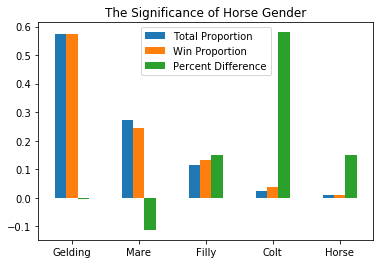

In [22]:
index = ['Gelding', 'Mare', 'Filly','Colt', 'Horse']

df1 = pd.DataFrame({'Total Proportion': horse_sex_pop,'Win Proportion': horse_sex_win , 'Percent Difference': horse_sex_percent_difference}, index=index)

ax = df1.plot.bar(rot=0,title='The Significance of Horse Gender')

### Using the Pearson's chi-squared test for both ways of finding population, I find horse gender isn't significant:

In [23]:
observed1 = horse_gender_population_cleaned.sex.value_counts().sort_values(ascending=False).drop('Unknown').values
expected_percentages1 = horse_sex_pop.values
expected1 = [x*observed1.sum() for x in expected_percentages1]

test_stat1, p_value1 = chisquare(observed1, expected1)

test_stat1, p_value1

(0.013579140930739166, 0.9999770549304412)

## For horse age:

In [24]:
#Removing races where there is only one age
age_population = df_grouped.age.value_counts(normalize=True,dropna=False).where(lambda x: x != 1).dropna()

age_population_indices = age_population.index.droplevel('age')

age_population_cleaned = df_cleaned.loc[age_population_indices].drop_duplicates()

In [25]:
age_population_cleaned.age.value_counts(normalize=True,dropna=False).sort_index()

2.00    0.01
3.00    0.17
4.00    0.29
5.00    0.23
6.00    0.15
7.00    0.08
8.00    0.04
9.00    0.02
10.00   0.00
11.00   0.00
12.00   0.00
Name: age, dtype: float64

In [26]:
age_win_indices = age_population_cleaned.position_again.apply(lambda x: x == 1)

age_population_cleaned[age_win_indices].age.value_counts(dropna=False,normalize=True).sort_index()

2.00    0.02
3.00    0.22
4.00    0.33
5.00    0.22
6.00    0.12
7.00    0.06
8.00    0.03
9.00    0.01
10.00   0.00
11.00   0.00
12.00   0.00
Name: age, dtype: float64

In [27]:
age_pop = age_population_cleaned.age.value_counts(dropna=False,normalize=True).sort_index()

age_win = age_population_cleaned[age_win_indices].age.value_counts(dropna=False,normalize=True).sort_index()

age_percent_difference = (age_win - age_pop)/age_pop

In [28]:
age_percent_difference

2.00     0.21
3.00     0.27
4.00     0.13
5.00    -0.06
6.00    -0.18
7.00    -0.29
8.00    -0.33
9.00    -0.37
10.00   -0.57
11.00   -0.38
12.00   -0.74
Name: age, dtype: float64

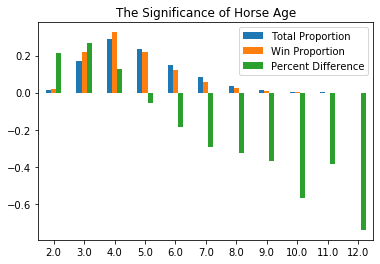

In [29]:
index = age_percent_difference.index

df2 = pd.DataFrame({'Total Proportion': age_pop,'Win Proportion': age_win , 'Percent Difference': age_percent_difference}, index=index)

ax = df2.plot.bar(rot=0, title='The Significance of Horse Age')

### Using the Pearson's chi-squared test, I find horse age is significant:

In [30]:
observed2 = age_population_cleaned[age_win_indices].age.value_counts().sort_index().values
expected_percentages2 = age_pop.values
expected2 = [x*observed2.sum() for x in expected_percentages2]

test_stat2, p_value2 = chisquare(observed2, expected2)

test_stat2, p_value2

(660.4154997913818, 1.962505610726143e-135)

## For handicap_weight:

In [31]:
#Removing races where there is only one age
weight_population = df_grouped.handicap_weight.value_counts(normalize=True,dropna=False).where(lambda x: x != 1).dropna()

weight_population_indices = weight_population.index.droplevel('handicap_weight')

weight_population_cleaned = df_cleaned.loc[weight_population_indices].drop_duplicates()

In [32]:
weight_population_cleaned.handicap_weight.describe()

count   182998.00
mean        56.91
std          2.21
min          5.00
25%         55.00
50%         57.00
75%         58.50
max         74.00
Name: handicap_weight, dtype: float64

In [33]:
weight_win_indices = weight_population_cleaned.position_again.apply(lambda x: x == 1)

weight_population_cleaned[weight_win_indices].handicap_weight.describe()

count   18753.00
mean       57.33
std         2.19
min        50.00
25%        56.00
50%        57.50
75%        58.50
max        74.00
Name: handicap_weight, dtype: float64

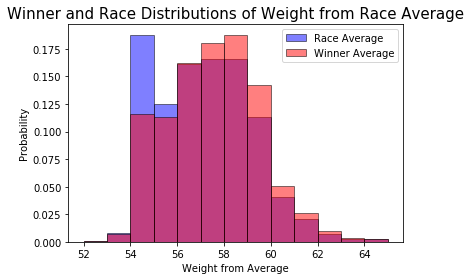

In [34]:
data7a = weight_population_cleaned.handicap_weight.dropna().values

data7b = weight_population_cleaned[weight_win_indices].handicap_weight.dropna().values

plt.title("Winner and Race Distributions of Weight from Race Average", fontsize=15)
plt.hist(data7a, density=True, bins=13, range=(52,65), label='Race Average', color='b', alpha=.5, edgecolor='k')
plt.hist(data7b, density=True, bins=13, range=(52,65), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Weight from Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, again I find that handicap_weight is significant:

In [35]:
test_stat7, p_value7 = ttest_ind(data7a, data7b)

test_stat7, p_value7

(-24.856354612251923, 3.5447101568237535e-136)

## For handicap_weight, using handicap weight_minus_average:

In [36]:
#I use the handicap_weight filters since the same races will be eliminated
weight_population_cleaned.weight_minus_average.describe()

count   182998.00
mean        -0.00
std          1.71
min        -48.67
25%         -1.17
50%         -0.10
75%          1.06
max         10.07
Name: weight_minus_average, dtype: float64

In [37]:
#average weight difference for winners
weight_population_cleaned[weight_win_indices].weight_minus_average.describe()

count   18753.00
mean        0.41
std         1.71
min        -6.56
25%        -0.83
50%         0.38
75%         1.44
max         8.86
Name: weight_minus_average, dtype: float64

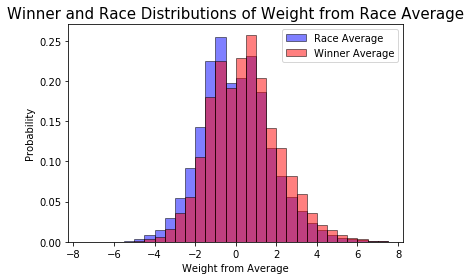

In [38]:
data2a = weight_population_cleaned.weight_minus_average.dropna().values

data2b = weight_population_cleaned[weight_win_indices].weight_minus_average.dropna().values

plt.title("Winner and Race Distributions of Weight from Race Average", fontsize=15)
plt.hist(data2a, density=True, bins=30, range=(-7.5,7.5), label='Race Average', color='b', alpha=.5, edgecolor='k')
plt.hist(data2b, density=True, bins=30, range=(-7.5,7.5), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Weight from Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that handicap weight_minus_average is significant:

In [39]:
test_stat2, p_value2 = ttest_ind(data2a, data2b)

test_stat2, p_value2

(-31.310659511199976, 1.0977714945388587e-214)

## For prize money, using prize_money_per_start_minus_average:

In [40]:
df_cleaned.prize_money_per_start_minus_average.describe()

count    171527.00
mean          0.00
std        7384.01
min     -135088.49
25%       -1190.81
50%        -306.63
75%         611.43
max      663484.79
Name: prize_money_per_start_minus_average, dtype: float64

In [41]:
#Winner prize money 
df_cleaned[general_win_indices].prize_money_per_start_minus_average.describe()

count    17525.00
mean      2379.62
std      12459.62
min     -81745.15
25%       -291.56
50%        580.13
75%       2222.76
max     663484.79
Name: prize_money_per_start_minus_average, dtype: float64

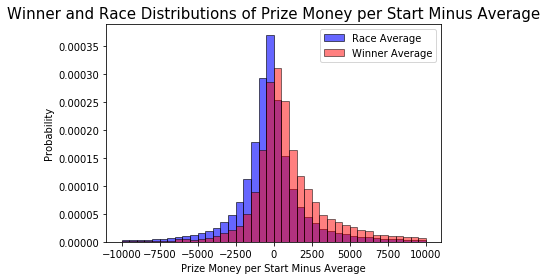

In [42]:
data3a = df_cleaned.prize_money_per_start_minus_average.dropna().values
data3b = df_cleaned[general_win_indices].prize_money_per_start_minus_average.dropna().values

plt.title("Winner and Race Distributions of Prize Money per Start Minus Average", fontsize=15)
plt.hist(data3a, density=True, bins=40, range=(-10000,10000), label='Race Average', color='b', alpha=.6, edgecolor='k')
plt.hist(data3b, density=True, bins=40, range=(-10000,10000), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Prize Money per Start Minus Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that prize money per start is significant:


In [43]:
test_stat3, p_value3 = ttest_ind(data3a, data3b)

test_stat3, p_value3

(-37.54902607474152, 2.0063482604638597e-307)

## For overall wins:

In [44]:
overall_pop = df_cleaned.overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_win = df_cleaned[general_win_indices].overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_percent_difference = (overall_win - overall_pop)/overall_pop

In [45]:
overall_percent_difference

(-0.002, 0.1]   -0.13
(0.1, 0.2]      -0.02
(0.2, 0.3]       0.16
(0.3, 0.4]       0.42
(0.4, 0.5]       0.67
(0.5, 0.6]       1.00
(0.6, 0.7]       1.14
(0.7, 0.8]       1.70
(0.8, 0.9]       2.50
(0.9, 1.0]       1.10
Name: overall_win_percent, dtype: float64

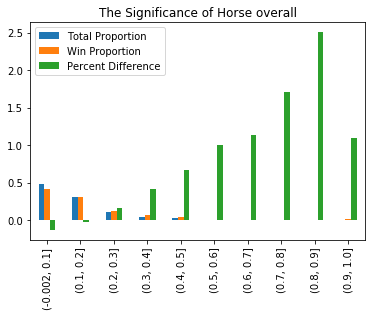

In [46]:
index = overall_percent_difference.index

df5 = pd.DataFrame({'Total Proportion': overall_pop,'Win Proportion': overall_win , 'Percent Difference': overall_percent_difference}, index=index)

ax = df5.plot.bar(title='The Significance of Horse overall')

### There is high variance in the 100% column (aka beginner's luck). How many races before the 100% column is properly represented? That is, how many races is considered statistically significant?

### 90-100% column should be roughly 3.90 or 390%

## For Barrier:

In [50]:
barrier_pop = df_cleaned.barrier.value_counts(normalize=True).sort_index().drop([18.00,19.00,20.00])

barrier_win = df_cleaned[general_win_indices].barrier.value_counts(normalize=True).sort_index().drop(18.00)

barrier_percent_difference = (barrier_win - barrier_pop)/barrier_pop

In [51]:
barrier_pop

1.00    0.10
2.00    0.10
3.00    0.10
4.00    0.10
5.00    0.10
6.00    0.10
7.00    0.09
8.00    0.08
9.00    0.07
10.00   0.06
11.00   0.04
12.00   0.03
13.00   0.02
14.00   0.01
15.00   0.00
16.00   0.00
17.00   0.00
Name: barrier, dtype: float64

In [52]:
barrier_win

1.00    0.12
2.00    0.10
3.00    0.10
4.00    0.11
5.00    0.11
6.00    0.11
7.00    0.09
8.00    0.07
9.00    0.06
10.00   0.05
11.00   0.03
12.00   0.02
13.00   0.01
14.00   0.01
15.00   0.00
16.00   0.00
17.00   0.00
Name: barrier, dtype: float64

In [53]:
barrier_percent_difference

1.00     0.22
2.00     0.03
3.00     0.06
4.00     0.10
5.00     0.12
6.00     0.09
7.00    -0.04
8.00    -0.11
9.00    -0.12
10.00   -0.19
11.00   -0.23
12.00   -0.23
13.00   -0.39
14.00   -0.40
15.00   -0.19
16.00   -0.45
17.00   -0.17
Name: barrier, dtype: float64

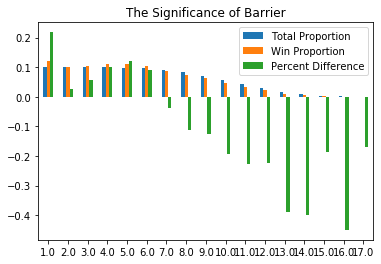

In [54]:
index = barrier_percent_difference.index

df3 = pd.DataFrame({'Total Proportion': barrier_pop,'Win Proportion': barrier_win , 'Percent Difference': barrier_percent_difference}, index=index)

ax = df3.plot.bar(rot=0, title='The Significance of Barrier')

#why is barrier 1 overrepresented? Is there a problem with the data?

### Using the Pearson's chi-squared test, I find that barrier is significant:

In [55]:
observed3 = df_cleaned[general_win_indices].barrier.value_counts().sort_index().drop(18.00).values
expected_percentages3 = barrier_pop.values
expected3 = [x*observed3.sum() for x in expected_percentages3]

test_stat3, p_value3 = chisquare(observed3, expected3)

test_stat3, p_value3

(403.57687781186564, 6.478757506142153e-76)

## For jockey gender: 

#### Overall percentage of men and women in races where both are represented:

In [56]:
expected3#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_population = df_grouped.jockey_sex.value_counts(normalize=True).where(lambda x: x != 1).dropna()

#Finds mean percent of jockey genders in races
#However, this method drops any race where there is a NaN value 
jockey_sex_population.mean(level=3)

jockey_sex
Male     0.74
Female   0.26
Name: jockey_sex, dtype: float64

In [57]:
jockey_sex_population_indices = jockey_sex_population.index

jockey_sex_population_cleaned = df_cleaned.loc[jockey_sex_population_indices].drop_duplicates()

#### Finding the total a different way:

In [58]:
jockey_sex_population_cleaned.jockey_sex.value_counts(normalize=True)
#This amount is the sum of all 'male' and 'female' jockeys added together and THEN 'normalized'

Male     0.75
Female   0.25
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [59]:
#Isolates wins in races with both jockey genders represented
jockey_sex_win_indices = jockey_sex_population_cleaned.position_again.apply(lambda x: x == 1)

jockey_sex_population_cleaned[jockey_sex_win_indices].jockey_sex.value_counts(normalize=True, dropna=False)

Male     0.79
Female   0.21
Name: jockey_sex, dtype: float64

In [60]:
#Finding the percent difference between win and total
jockey_sex_pop = jockey_sex_population_cleaned.jockey_sex.value_counts(normalize=True, dropna=False).values

jockey_sex_win = jockey_sex_population_cleaned[jockey_sex_win_indices].jockey_sex.value_counts(normalize=True, dropna=False).values

jockey_sex_percent_difference = (jockey_sex_win - jockey_sex_pop)/jockey_sex_pop

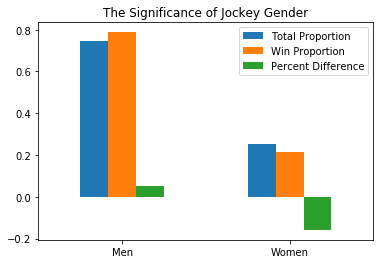

In [61]:
index = ['Men','Women']

df4 = pd.DataFrame({'Total Proportion': jockey_sex_pop,'Win Proportion': jockey_sex_win , 'Percent Difference': jockey_sex_percent_difference}, index=index)

ax = df4.plot.bar(rot=0, title='The Significance of Jockey Gender')

### Using a 2-proportion z-test, I find that jockey gender is significant with a p-value of 2.3E-30
#### (There is currently a bug with the statsmodels library concering compatibility with scipy, so I used a scientific calculator)